# Visualization Examples using Cedalion Plot Functions
This notebook will be continuously extended. We un-necessarily re-import cedalion dependencies to clarify which of these are needed for the plots in each corresponding cell. PLEASE NOTE: we are in the process of re-organizing the locations for our plotting functions. This notebook will be kept up to date with the latest release to enable an easy look up. 

## Importing Packages
### 3rd party plotting packages
Most of Cedalion's plotting functionality is based on Matplotlib and Pyvista packages

In [1]:
import pyvista as pv
pv.set_jupyter_backend('html') # this enables interactive plots
#pv.set_jupyter_backend('static') # this enables static rendering
#pv.OFF_SCREEN=True

import matplotlib.pyplot as p

### Other packages that will be useful in this notebook
Dependencies for data processing and manipulation. 

In [2]:
import time
import numpy as np
import xarray as xr

## Load Data for Visuatization
This cell fetches a variety example datasets from the cloud for visualization. This can take a bit of time.

In [3]:
import cedalion
import cedalion.datasets
import cedalion.io
import cedalion.imagereco.forward_model as fw

# Loads a high-density finger tapping fNIRS example snirf dataset into a recording container
cedalion.units
rec = cedalion.datasets.get_fingertappingDOT()

# Loads a photogrammetric example scan
fname_scan, fname_snirf, fname_montage = cedalion.datasets.get_photogrammetry_example_scan()
pscan = cedalion.io.read_einstar_obj(fname_scan)

# Loads a precalculated example fluence profile that does not belong with this recording though
fluence_all, fluence_at_optodes = cedalion.datasets.get_imagereco_example_fluence()

# Lads a segmented MRI Scan (here the Colin27 average brain) and creates a TwoSurfaceHeadModel
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()
head = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    landmarks_ras_file=landmarks_file
)


## Plotting Time Series Using Matplotlib
We are working on a nice function that abstracts most of the work away from you. Until then you will have use standard python matplotlib functions.

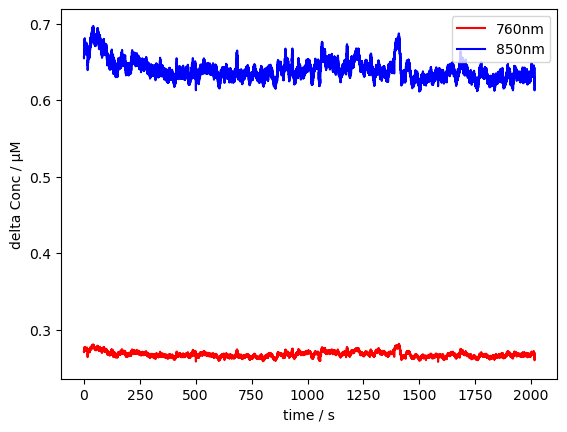

In [8]:
# Thanks to the xarray DataArray structure, we can easily select the data we want to plot
p.figure()
p.plot(rec["amp"].time, rec["amp"].sel(channel="S1D2", wavelength="760"), "r-", label="760nm")
p.plot(rec["amp"].time, rec["amp"].sel(channel="S1D2", wavelength="850"), "b-", label="850nm")

# axis labels
p.xlabel("time / s")
p.ylabel("delta Conc / µM")

# Adding the custom legend
p.legend(loc='upper right')

## Scalp Plot
Plots a metric, e.g. channel quality or amplitude at a time point on the scalp.

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


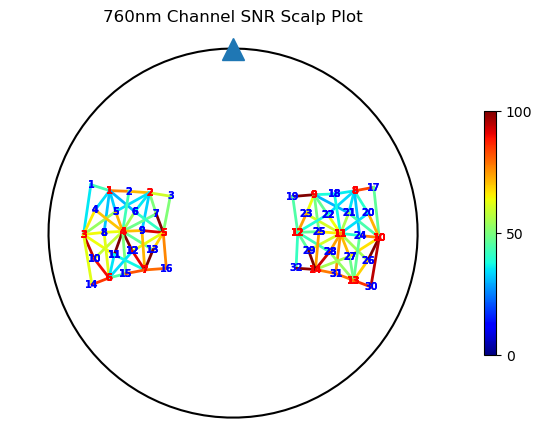

In [10]:
import cedalion.plots as plots
import cedalion.sigproc.quality as quality
import matplotlib.pyplot as plt 

n_channels = len(rec["amp"].channel)
# Calculate channel SNR to display as a metric in the plot
snr, snr_mask = quality.snr(rec["amp"], 3)
# the plots "metric" input needs dimension (nchannels,) so we focus on the 760nm wavelength for each channel
snr_metric = snr.sel(wavelength="760").values

# Create scalp plot showing SNR in each channel
fig, ax = plt.subplots(1,1)
plots.scalp_plot(rec, snr_metric, ax, colormap=plt.cm.jet, title='760nm Channel SNR Scalp Plot', vmin=0, vmax=n_channels, savePath = None, flagFontSize=7, flagMarkerSize=0)


## Plotting Time Series Using an interactive GUI
run_vis() from the vis.timeseries package

![image](../docs/img/time_series_guiexample.png)

In [9]:
from cedalion.vis import time_series

# this calls a GUI to interactively select channels from a 2D probe. 
# Input is a recording container, you can choose which time series (e.g. raw, OD, concentrations) in the container  to plot
time_series.run_vis(rec)

SystemExit: 0

## Plotting a probe using an interactive GUI
run_vis() from the vis.plot_probe package

In [ ]:
from cedalion.vis import plot_probe
# plot_probe.run_vis(rec["amp"]) #FIXME

## Plotting an fNIRS Montage in 3D
Using **plot_montage3D()**

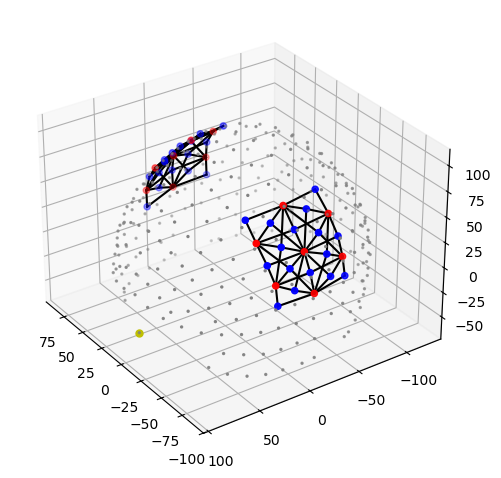

In [4]:
import cedalion.plots

# use the plot_montage3D() function. It requires a recording container and a geo3d object
cedalion.plots.plot_montage3D(rec["amp"], rec.geo3d)

## Plotting a Headmodel
For instance the default Colin27 or ICBM152, using **plot_surface()**

In [5]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
plt.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

### Adding a montage to the headmodel
For this the montage has to be registered to the headmodel's scalp first. Then we use **plot_labeled_points**

In [6]:
geo3d_snapped = head.align_and_snap_to_scalp(rec.geo3d)

# now we plot the head same as before...
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
# but use the plot_labeled_points() function to add the snapped geo3d. The flag "show_labels" can be used to show the source, detector, and landmark names 
cedalion.plots.plot_labeled_points(plt, geo3d_snapped, show_labels=True)
plt.show()

Widget(value='<iframe src="http://localhost:61790/index.html?ui=P_0x16c19452350_1&reconnect=auto" class="pyvis…

## Surface Plot of 3D Scans
Uses the same function as for head models, **plot_surface()**

In [ ]:
import cedalion.plots

plt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(plt, pscan, opacity=1.0)
plt.show(interactive = True)

## Interactive 3D Plot to select Landmarks
using **plot_surface** with "pick_landmarks = True". Here we use a photogrammetric scan, and the landmarks are indicated by green dots. Right-clicking again on an existing landmark changes the label.

In [12]:
import cedalion.plots

plt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(plt, pscan, opacity=1.0, pick_landmarks = True)
plt.show(interactive = True)

Widget(value='<iframe src="http://localhost:61790/index.html?ui=P_0x16c022e9410_2&reconnect=auto" class="pyvis…

In [14]:
# when you are done run get_landmarks() to get the landmarks
landmark_coordinates, landmark_labels = get_landmarks()
display (landmark_labels)

['Nz', 'Iz', 'Nz', 'Nz', 'Nz']

## Plot ImageRecon HRF Activation (from HD fNIRS/DOT) on Cortex
Since this requires a lot of preprocessing, please use the Image Reconstruction Jupyter Example Notebook [HERE](https://github.com/ibs-lab/cedalion/blob/main/examples/image_reconstruction.ipynb)

## Upcoming (WIP): Plot Probe Sensitivity on Cortex

Upcoming (WIP): 